In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.spatial.distance import cdist


### Kernel functions

In [ ]:
k=10

def compute_polynomial_kernel(P, Q, d=3):
    # dot product between pat and each row in dat
    if P.ndim == 1:
        P = P.reshape(1, -1)
    K = (np.dot(P, Q.T)) ** d
    return K

def compute_gaussian_kernel(P, Q, c):
    if P.ndim == 1:
        P = P.reshape(1, -1)
    # distance = np.sum((P[:, np.newaxis, :] - Q)**2, axis=2)
    distance_sq = cdist(P, Q, 'sqeuclidean')
    return np.exp(-c * distance_sq)

### utility functions

In [ ]:
# Useful functions

def mysign(x):
    return np.where(x <= 0.0, -1.0, 1.0)
    # return -1.0 if x <= 0.0 else 1.0

# def softmax(scores):
#     """Compute softmax values to get probability"""
#     e_scores = np.exp(scores - np.max(scores))  # subtract max to stabilize
#     return e_scores / e_scores.sum(axis=0)

def plotChar(char):
    # Extract the relevant part of the array
    # Visualizes a digit from its pixel values 
    
    rep = char[1:257]
    # Reshape the array into a 16x16 grid
    data = np.array([rep[16*i:16*(i+1)] for i in range(15, -1, -1)])

    # Create a density plot
    plt.imshow(data)
    # plt.colorbar()
    plt.title(f"The number {char[0]}")
    plt.show()

def get_train_test(df,split_proportion=0.8):
    """
     Splits data into train and test sets based on split_proportion.
     Args:
     	 df: pandas dataframe to be split
     	 split_proportion: proportion of all samples to be used for training

     Returns:
     	 trainX, trainY, testX, testY
    """
    shuffledidx = np.random.permutation(df.index)
    m = len(df.index)
    nsamples_train = int(split_proportion*m)
    train = df.iloc[shuffledidx[:nsamples_train]].to_numpy()
    test = df.iloc[shuffledidx[nsamples_train:]].to_numpy()

    return train, test

def create_confusion_matrix(true_y, predicted_y):
    # Builds a confusion matrix using true and predicted labels.
    labels = np.unique(true_y)
    n_labels = len(labels)
    conf_matrix = np.zeros((n_labels,n_labels))

    for t,p in zip(true_y, predicted_y):
        if t!=p:
            conf_matrix[t,p]+=1
    return conf_matrix
# cm = create_confusion_matrix(true_y, predicted_y)
# print(cm)
# plt.imshow(cm)

### Kernel Perceptron Classifier

This class encapsulates a multi-class kernel perceptron implementation

In [3]:
class kPerceptron:
    def __init__(self, kclasses = 3, debug=False):
        self.kclasses = kclasses
        self.train_fixed_epochs = True
        self.debug = debug
        self.showComputationTime = False

    def map_labels(self):
        """ identify all unique labels in dataset and map them to a range from 0 to k-1,
        where k is the number of unique labels. """
        unique_labels = np.unique(self.trainY)
        self.label_to_index = {label: index for index, label in enumerate(unique_labels)}
        if self.debug:
            print('Mapping:',self.label_to_index)
        self.index_to_label = {index: label for index, label in enumerate(unique_labels)}

    def compute_all_confidences(self, current_kernel_matrix):
        """ Computes the confidences for all classifiers """
        # Perform a matrix multiplication between the classifiers and the kernel matrix
        conf_all = np.dot(self.classifiers_weights, current_kernel_matrix)
        return conf_all
    
    def getweights(self):
        return self.classifiers_weights  # Alpha in pseudocode
    
    def _predict(self,current_kernel_matrix):
        conf_all = self.compute_all_confidences(current_kernel_matrix)
        # Choose the class with the highest confidence
        predicted_idx = np.argmax(conf_all)
        prediction = self.index_to_label[predicted_idx]
        return prediction

    def trainOneEpoch(self):
        """code to train model by updating weights of all classifiers - for single epoch
         - iteratively updates classifier weights for each training point """
        mistakes = 0

        for i in range(self.len_trainset):
            current_label = self.mapped_labels[i]  # label of current idx

            #confidences of all k classifiers
            # kernel_matrix = compute_polynomial_kernel(X[i], X, poly_dim).flatten() # online training
            current_kernel_matrix = self.K_train[i].flatten() # transformation of current input features
            conf_all = self.compute_all_confidences(current_kernel_matrix)

            # conf_all = [classpredk(kernel_matrix , my_classifiers[j]) for j in range(k)]
            # probs = softmax(conf_all)

            # update classifier weights if classifier prediction is wrong
            y = np.where(np.arange(self.kclasses) == current_label, 1.0, -1.0) #classifier prediction corresponding to the current_label is set to 1.0, and all others are set to -1.0
            weight_updates = mysign(conf_all) * (y * conf_all <= 0) # weight_updates will be non-zero for classifiers that need an update
            self.classifiers_weights[:, i] -= weight_updates

            # Predict by maximizing confidence
            max_confidence_idx = np.argmax(conf_all)
            if max_confidence_idx != current_label:
                mistakes += 1
        self.mistakes = mistakes
        if self.debug:
            print("------ Error %:",mistakes/self.len_trainset)

    def fit_online(self, trainX, trainY, kernel_matrix_train, n_epochs, method='polynomial',poly_dim=None, gauss_c=None, validation = False):
        """fit model to training data"""
        self.trainX = trainX
        self.trainY = trainY
        self.K_train = kernel_matrix_train
        self.len_trainset = len(self.trainY)
        self.kclasses = len(np.unique(trainY))
        self.poly_dim = poly_dim
        self.gauss_c = gauss_c
        self.method=method
        self.validation = validation

        if self.validation:
            # here just to find optimal number of epochs
            self.validationX = self.trainX[int(self.len_trainset*0.8):,:]
            self.validationY = self.trainY[int(self.len_trainset*0.8):]
            self.trainX = self.trainX[:int(self.len_trainset*0.8),:]
            # print(self.trainX)
            self.trainY = self.trainY[:int(self.len_trainset*0.8)]
            # print('len of validation set',self.validationY)
            train_errors = []
            val_errors = []
            self.len_trainset = len(self.trainY)
            if self.method == 'polynomial':
                self.K_train = compute_polynomial_kernel(self.trainX,self.trainX, self.poly_dim)
            elif self.method == 'gaussian':
                self.K_train = compute_gaussian_kernel(self.trainX,self.trainX, self.gauss_c)

        # if self.validation:
        #     self.n_epochs = n_epochs
        #     self.train_fixed_epochs = True
        # else:
        #     self.train_fixed_epochs = False #TODO: validation to do early stopping

        self.classifiers_weights = np.zeros((self.kclasses, self.len_trainset)) # Alpha

        # labels have to be mapped to classifier index
        self.map_labels()
        self.mapped_labels = np.array([self.label_to_index[y_val] for y_val in self.trainY])

        # if self.train_fixed_epochs:
        ###############
        for current_epoch in range(1,n_epochs+1):
            # Training
            if self.showComputationTime:
                start_time = time.time()
            self.trainOneEpoch()
            if self.showComputationTime:
                training_time = time.time() - start_time
                print(f"------ Training time: {training_time:.2f} seconds") # with {mistakes} mistakes out of {len(train)} items.")
            train_error = round(self.mistakes/self.len_trainset,4)
            if self.validation:
              train_errors.append(train_error)

            # Validation
            if self.validation:
              _,val_error = self.test(self.validationX, self.validationY)
              val_errors.append(val_error)

            print(f'---->Epoch {current_epoch}, train_error: {train_error} ')
        if validation:
            return train_errors,val_errors
        return train_error
            ###################
    
    def test(self,testX,testY):
        """ use model to predict new test point - if given a dataset, it iteratively predicts every point """
        # assert self.poly_dim!=None
        mistakes = 0
        len_testset = len(testY)
        # print('len_testset',len_testset)
        if len_testset == 1:
            testX = testX.reshape(1, -1)
        # mapped_testlabels = np.array([self.label_to_index[y_val] for y_val in testY])
            
        if self.method == 'polynomial':
            # assert self.poly_dim!=None
            test_kernel_matrix = compute_polynomial_kernel(testX,self.trainX, self.poly_dim)
        elif self.method == 'gaussian':
            test_kernel_matrix = compute_gaussian_kernel(testX,self.trainX, self.gauss_c)
        preds = []

        if self.showComputationTime:
            start_time = time.time()
        for i in range(len_testset):
            true_y = testY[i]  # label of current idx
            # test_point = testX[i]

            #confidence of each classifier on the test point
            # conf_all = [classpredk(X, test_point, my_classifiers[j], poly_dim) for j in range(k)]
            # current_kernel_matrix = compute_polynomial_kernel(test_point, self.trainX, self.poly_dim).flatten()
            current_kernel_matrix = test_kernel_matrix[i].flatten()
            prediction = self._predict(current_kernel_matrix)
            preds.append(prediction)
            # if self.debug:
            #     print(prediction, true_y)
            if prediction != true_y:
                mistakes += 1
                # print(f"i:{i}, Mistake, true_y={true_y}, predicted {prediction}")
                # time.sleep(0.1)
        if self.debug:
                print('Test mistakes: ',mistakes)

        # test error = number of mistakes divided by test set size
        test_error = mistakes / len_testset
        print(f'---> Test_error: {test_error} ')

        if self.showComputationTime:
            testing_time = time.time() - start_time
            print(f"------ Testing time: {testing_time:.2f} seconds") # with {mistakes} mistakes out of {len(train)} items.")
        return preds, test_error


#### Testing 3 class dataset

In [9]:
# # Using 3 class dataset
# train_df = pd.read_csv('dtrain123.dat',header=None,delim_whitespace=True)
# test_df = pd.read_csv('dtest123.dat',header=None,delim_whitespace=True)

# train_data123 = train_df.to_numpy()
# test_data123 = test_df.to_numpy()
# # train_data123 = np.genfromtxt('dtrain123.dat')
# # test_data123 = np.genfromtxt('dtest123.dat')
# print(train_data123.shape)

# temp_trainX = train_data123[:, 1:]
# temp_trainY = train_data123[:, 0]
# temp_testX = test_data123[:, 1:]
# temp_testX = test_data123[:, 1:]
# temp_testY = test_data123[:, 0]
# # validation_data = train_data123[:10]

# poly_dim = 3 # dimension of the polynomial - kernel
# K_train = compute_polynomial_kernel(temp_trainX, temp_trainX, poly_dim)

# n_epochs = 3
# model = kPerceptron(kclasses=3, debug=True)
# train_error = model.fit_online(trainX= temp_trainX, trainY = temp_trainY, kernel_matrix_train = K_train, n_epochs=n_epochs, poly_dim=poly_dim)
# preds, test_error = model.test(temp_testX,temp_testY)

#### 10 class dataset

In [4]:
dataset_alldigits = pd.read_csv('zipcombo.dat',header=None,delim_whitespace=True)
polydim_values = np.arange(1,8)

In [5]:
# plot_learning_curves
def plot_learning_curves(train_errors, val_errors, param):
    epochs = range(1, len(train_errors) + 1)
    plt.plot(epochs, train_errors, label='Training error')

    if val_errors[0] is not None:
        plt.plot(epochs, val_errors, label='Validation error')

    plt.title(f'Learning Curves for param:{param}')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()


7438 1860
poly_dim:  1
---> Test_error: 0.11223118279569892 
---->Epoch 1, train_error: 0.1348 
---> Test_error: 0.10685483870967742 
---->Epoch 2, train_error: 0.0855 
---> Test_error: 0.09744623655913978 
---->Epoch 3, train_error: 0.0745 
---> Test_error: 0.07728494623655914 
---->Epoch 4, train_error: 0.0679 
---> Test_error: 0.11021505376344086 
---->Epoch 5, train_error: 0.064 
---> Test_error: 0.0961021505376344 
---->Epoch 6, train_error: 0.0627 
---> Test_error: 0.08400537634408602 
---->Epoch 7, train_error: 0.0603 
---> Test_error: 0.08198924731182795 
---->Epoch 8, train_error: 0.0566 
---> Test_error: 0.08803763440860216 
---->Epoch 9, train_error: 0.0555 
---> Test_error: 0.08534946236559139 
---->Epoch 10, train_error: 0.0518 
---> Test_error: 0.07795698924731183 
---->Epoch 11, train_error: 0.0499 
---> Test_error: 0.0846774193548387 
---->Epoch 12, train_error: 0.0508 
---> Test_error: 0.07526881720430108 
---->Epoch 13, train_error: 0.0511 
---> Test_error: 0.08198924

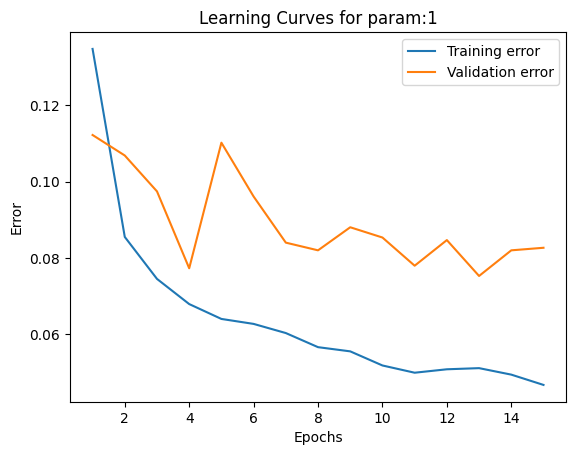

poly_dim:  2
---> Test_error: 0.05510752688172043 
---->Epoch 1, train_error: 0.0882 
---> Test_error: 0.038306451612903226 
---->Epoch 2, train_error: 0.0242 
---> Test_error: 0.038306451612903226 
---->Epoch 3, train_error: 0.0156 
---> Test_error: 0.03763440860215054 
---->Epoch 4, train_error: 0.0077 
---> Test_error: 0.033602150537634407 
---->Epoch 5, train_error: 0.0072 
---> Test_error: 0.03696236559139785 
---->Epoch 6, train_error: 0.0049 
---> Test_error: 0.035618279569892476 
---->Epoch 7, train_error: 0.0042 
---> Test_error: 0.031586021505376344 
---->Epoch 8, train_error: 0.0039 
---> Test_error: 0.03225806451612903 
---->Epoch 9, train_error: 0.002 
---> Test_error: 0.027553763440860215 
---->Epoch 10, train_error: 0.0018 
---> Test_error: 0.028225806451612902 
---->Epoch 11, train_error: 0.0012 
---> Test_error: 0.02620967741935484 
---->Epoch 12, train_error: 0.001 
---> Test_error: 0.028225806451612902 
---->Epoch 13, train_error: 0.001 
---> Test_error: 0.0248655913

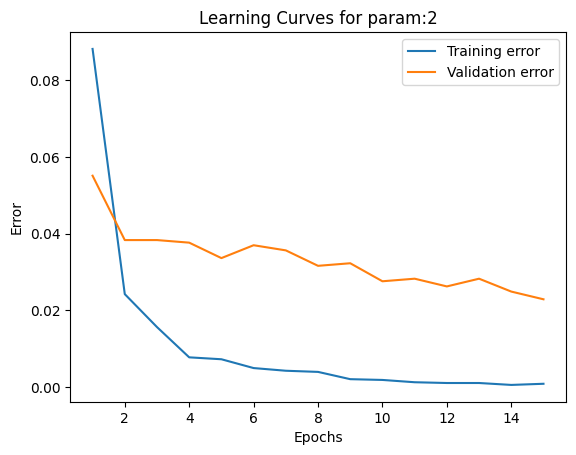

poly_dim:  3
---> Test_error: 0.04771505376344086 
---->Epoch 1, train_error: 0.0792 
---> Test_error: 0.031586021505376344 
---->Epoch 2, train_error: 0.0138 
---> Test_error: 0.03225806451612903 
---->Epoch 3, train_error: 0.0052 
---> Test_error: 0.02956989247311828 
---->Epoch 4, train_error: 0.0034 
---> Test_error: 0.031586021505376344 
---->Epoch 5, train_error: 0.0017 
---> Test_error: 0.026881720430107527 
---->Epoch 6, train_error: 0.0012 
---> Test_error: 0.024193548387096774 
---->Epoch 7, train_error: 0.0007 
---> Test_error: 0.025537634408602152 
---->Epoch 8, train_error: 0.0012 
---> Test_error: 0.02889784946236559 
---->Epoch 9, train_error: 0.0005 
---> Test_error: 0.025537634408602152 
---->Epoch 10, train_error: 0.0008 
---> Test_error: 0.02486559139784946 
---->Epoch 11, train_error: 0.0005 
---> Test_error: 0.024193548387096774 
---->Epoch 12, train_error: 0.0007 
---> Test_error: 0.023521505376344086 
---->Epoch 13, train_error: 0.0003 
---> Test_error: 0.0221774

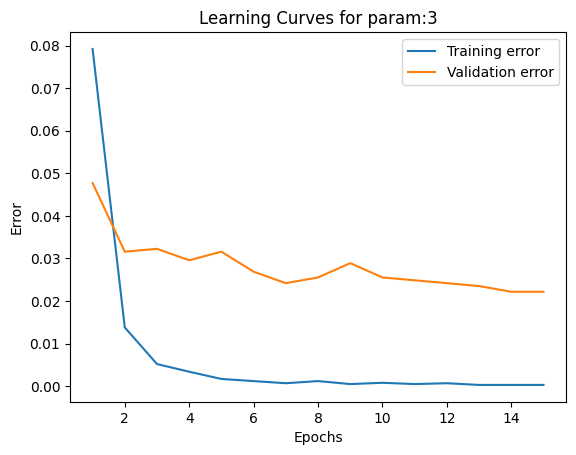

poly_dim:  4
---> Test_error: 0.04771505376344086 
---->Epoch 1, train_error: 0.0704 
---> Test_error: 0.03494623655913978 
---->Epoch 2, train_error: 0.0113 
---> Test_error: 0.02620967741935484 
---->Epoch 3, train_error: 0.0064 
---> Test_error: 0.026881720430107527 
---->Epoch 4, train_error: 0.0012 
---> Test_error: 0.0228494623655914 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.02620967741935484 
---->Epoch 6, train_error: 0.0005 
---> Test_error: 0.025537634408602152 
---->Epoch 7, train_error: 0.0008 
---> Test_error: 0.023521505376344086 
---->Epoch 8, train_error: 0.0008 
---> Test_error: 0.02889784946236559 
---->Epoch 9, train_error: 0.0013 
---> Test_error: 0.025537634408602152 
---->Epoch 10, train_error: 0.0002 
---> Test_error: 0.024193548387096774 
---->Epoch 11, train_error: 0.0003 
---> Test_error: 0.023521505376344086 
---->Epoch 12, train_error: 0.0002 
---> Test_error: 0.024193548387096774 
---->Epoch 13, train_error: 0.0003 
---> Test_error: 0.024193548

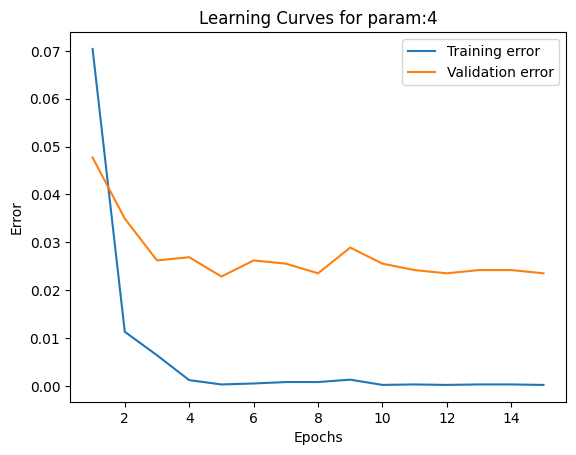

poly_dim:  5
---> Test_error: 0.03225806451612903 
---->Epoch 1, train_error: 0.0672 
---> Test_error: 0.027553763440860215 
---->Epoch 2, train_error: 0.0109 
---> Test_error: 0.02620967741935484 
---->Epoch 3, train_error: 0.0027 
---> Test_error: 0.026881720430107527 
---->Epoch 4, train_error: 0.0015 
---> Test_error: 0.025537634408602152 
---->Epoch 5, train_error: 0.0005 
---> Test_error: 0.02217741935483871 
---->Epoch 6, train_error: 0.0003 
---> Test_error: 0.023521505376344086 
---->Epoch 7, train_error: 0.0008 
---> Test_error: 0.02217741935483871 
---->Epoch 8, train_error: 0.0003 
---> Test_error: 0.020161290322580645 
---->Epoch 9, train_error: 0.0005 
---> Test_error: 0.020833333333333332 
---->Epoch 10, train_error: 0.0003 
---> Test_error: 0.021505376344086023 
---->Epoch 11, train_error: 0.0003 
---> Test_error: 0.02217741935483871 
---->Epoch 12, train_error: 0.0003 
---> Test_error: 0.021505376344086023 
---->Epoch 13, train_error: 0.0005 
---> Test_error: 0.0215053

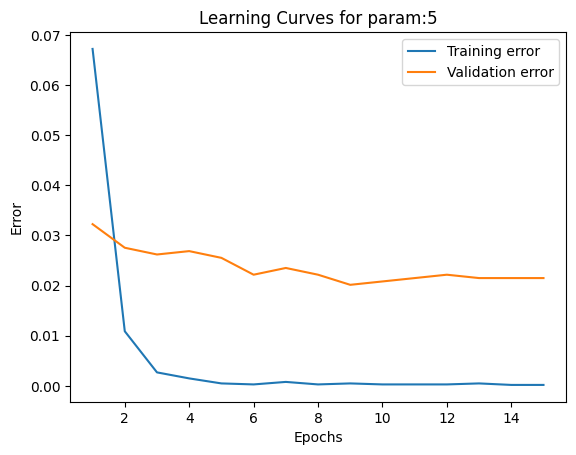

poly_dim:  6
---> Test_error: 0.03763440860215054 
---->Epoch 1, train_error: 0.0677 
---> Test_error: 0.030913978494623656 
---->Epoch 2, train_error: 0.0091 
---> Test_error: 0.02620967741935484 
---->Epoch 3, train_error: 0.0022 
---> Test_error: 0.0228494623655914 
---->Epoch 4, train_error: 0.0012 
---> Test_error: 0.026881720430107527 
---->Epoch 5, train_error: 0.0005 
---> Test_error: 0.02217741935483871 
---->Epoch 6, train_error: 0.0008 
---> Test_error: 0.021505376344086023 
---->Epoch 7, train_error: 0.0005 
---> Test_error: 0.021505376344086023 
---->Epoch 8, train_error: 0.0002 
---> Test_error: 0.021505376344086023 
---->Epoch 9, train_error: 0.0002 
---> Test_error: 0.021505376344086023 
---->Epoch 10, train_error: 0.0002 
---> Test_error: 0.02217741935483871 
---->Epoch 11, train_error: 0.0002 
---> Test_error: 0.021505376344086023 
---->Epoch 12, train_error: 0.0002 
---> Test_error: 0.021505376344086023 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.02217741935

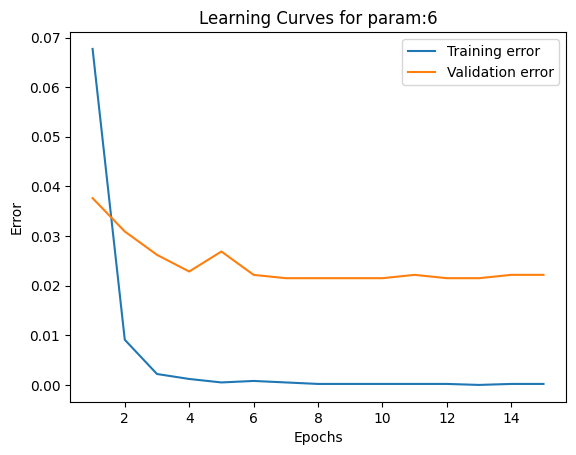

poly_dim:  7
---> Test_error: 0.03293010752688172 
---->Epoch 1, train_error: 0.0689 
---> Test_error: 0.027553763440860215 
---->Epoch 2, train_error: 0.0084 
---> Test_error: 0.027553763440860215 
---->Epoch 3, train_error: 0.0018 
---> Test_error: 0.028225806451612902 
---->Epoch 4, train_error: 0.0008 
---> Test_error: 0.0228494623655914 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.020833333333333332 
---->Epoch 6, train_error: 0.0003 
---> Test_error: 0.019489247311827957 
---->Epoch 7, train_error: 0.0003 
---> Test_error: 0.02217741935483871 
---->Epoch 8, train_error: 0.0003 
---> Test_error: 0.020833333333333332 
---->Epoch 9, train_error: 0.0002 
---> Test_error: 0.020161290322580645 
---->Epoch 10, train_error: 0.0002 
---> Test_error: 0.02217741935483871 
---->Epoch 11, train_error: 0.0002 
---> Test_error: 0.02217741935483871 
---->Epoch 12, train_error: 0.0005 
---> Test_error: 0.02217741935483871 
---->Epoch 13, train_error: 0.0003 
---> Test_error: 0.021505376

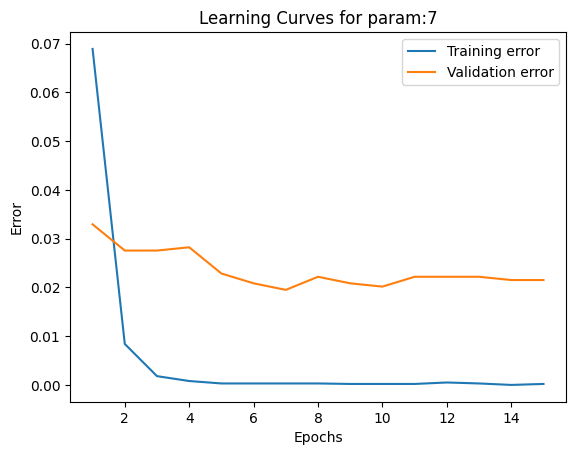

[13, 15, 14, 5, 9, 7, 7]


In [12]:
# Code to determine right number of epochs
nsamples_train = int(len(dataset_alldigits)*0.8)
train_data10 = dataset_alldigits.iloc[:nsamples_train].to_numpy()
test_data10 = dataset_alldigits.iloc[nsamples_train:].to_numpy()
train_data10X, train_data10Y = train_data10[:, 1:], train_data10[:, 0]
test_data10X, test_data10Y = test_data10[:, 1:], test_data10[:, 0]
print(len(train_data10), len(test_data10))

n_epochs = 15

# model = kPerceptron(kclasses=10, debug=True)
# train_error = model.fit_online(trainX= train_data10X, trainY = train_data10Y, kernel_matrix_train = K_train, n_epochs=n_epochs, poly_dim=poly_dim)
# preds, test_error = model.test(test_data10X,test_data10Y)
# # print(train_error, test_error)

epochnum_minValidationError = []
for poly_dim in np.arange(1,8):
    print('poly_dim: ',poly_dim)
    # poly_dim = 4 # dimension of the polynomial - kernel
    K_train = compute_polynomial_kernel(train_data10X, train_data10X, poly_dim)
    model = kPerceptron(kclasses=10, debug=False)
    train_errors, val_errors = model.fit_online(train_data10X, train_data10Y, K_train, n_epochs,method='polynomial', poly_dim=poly_dim, validation=True)
    plot_learning_curves(train_errors, val_errors,poly_dim)
    epochnum_minValidationError.append(np.argmin(val_errors)+1)
print(epochnum_minValidationError)

In [13]:
print(epochnum_minValidationError) # 13,15,14,5,9,7,7
import statistics

n_epochs = statistics.median(epochnum_minValidationError)
print(n_epochs)
# n_epochs = 9 # 9 is what we got as median

[13, 15, 14, 5, 9, 7, 7]
9


### Basic Results

1. Basic Results: Perform 20 runs for d = 1, . . . , 7 each run should randomly split zipcombo into 80%
train and 20% test. Report the mean test and train error rates as well as well as standard deviations.
Thus your data table, here, will be 2 × 7 with each “cell” containing a mean±std.

In [14]:
# Code for Q1
train_error_polydim = {}
test_error_polydim = {}
for idx in polydim_values:
    train_error_polydim[idx] = []
    test_error_polydim[idx] = []

start_time = time.time()
n_epochs = 9 # optimized by taking median of indexes giving best validation error
for repeat in range(20): #TODO: 20

    print(f'Run {repeat+1}/20: ')
    # Split data into train and test
    train_data, test_data = get_train_test(dataset_alldigits,split_proportion=0.8)
    trainX, trainY = train_data[:, 1:], train_data[:, 0]
    testX, testY = test_data[:, 1:], test_data[:, 0]
    # print(len(test_data), len(test_data), trainY[0], testY[0] )

    for poly_dim in polydim_values:
        print(f'poly_dim: {poly_dim}')
        K_train = compute_polynomial_kernel(trainX, trainX, poly_dim)

        model = kPerceptron(kclasses=10, debug=False)
        train_error = model.fit_online(trainX= trainX, trainY = trainY, kernel_matrix_train = K_train, n_epochs=n_epochs, poly_dim=poly_dim)
        _,test_error = model.test(testX, testY)

        train_error_polydim[poly_dim].append(train_error)
        test_error_polydim[poly_dim].append(test_error)

testing_time = time.time() - start_time
print(f"Algorithm took {testing_time:.2f} seconds")

Run 1/20: 
poly_dim: 1
---->Epoch 1, train_error: 0.1459 
---->Epoch 2, train_error: 0.0932 
---->Epoch 3, train_error: 0.0862 
---->Epoch 4, train_error: 0.0804 
---->Epoch 5, train_error: 0.0752 
---->Epoch 6, train_error: 0.0731 
---->Epoch 7, train_error: 0.0727 
---->Epoch 8, train_error: 0.0686 
---->Epoch 9, train_error: 0.0668 
---> Test_error: 0.10752688172043011 
poly_dim: 2
---->Epoch 1, train_error: 0.0941 
---->Epoch 2, train_error: 0.035 
---->Epoch 3, train_error: 0.021 
---->Epoch 4, train_error: 0.0134 
---->Epoch 5, train_error: 0.0082 
---->Epoch 6, train_error: 0.0071 
---->Epoch 7, train_error: 0.0052 
---->Epoch 8, train_error: 0.0046 
---->Epoch 9, train_error: 0.0027 
---> Test_error: 0.038172043010752686 
poly_dim: 3
---->Epoch 1, train_error: 0.0757 
---->Epoch 2, train_error: 0.0199 
---->Epoch 3, train_error: 0.0078 
---->Epoch 4, train_error: 0.0051 
---->Epoch 5, train_error: 0.0024 
---->Epoch 6, train_error: 0.0023 
---->Epoch 7, train_error: 0.0019 
---

In [15]:
# 1. Answers
mean_train_error, mean_test_error, sd_train_error, sd_test_error = {}, {}, {}, {}

for key, values in train_error_polydim.items():
    mean_train_error[key] = np.mean(values)
    sd_train_error[key] = np.std(values)
for key, values in test_error_polydim.items():
    mean_test_error[key] = np.mean(values)
    sd_test_error[key] = np.std(values)

print('Mean of Train errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in mean_train_error.items()))
print('SD of Train errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in sd_train_error.items()))
print('Mean of Test errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in mean_test_error.items()))
print('SD of Test errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in sd_test_error.items()))

Mean of Train errors for each d 
  1: 0.068895, 2: 0.002905, 3: 0.000630, 4: 0.000360, 5: 0.000305, 6: 0.000270, 7: 0.000195
SD of Train errors for each d 
  1: 0.002755, 2: 0.000467, 3: 0.000251, 4: 0.000196, 5: 0.000196, 6: 0.000182, 7: 0.000169
Mean of Test errors for each d 
  1: 0.087473, 2: 0.035081, 3: 0.028602, 4: 0.027634, 5: 0.026935, 6: 0.027285, 7: 0.027688
SD of Test errors for each d 
  1: 0.012273, 2: 0.005198, 3: 0.005239, 4: 0.003515, 5: 0.002677, 6: 0.003283, 7: 0.004039


### Cross validation for best polynomial degree

Cross-validation: Perform 20 runs : when using the 80% training data split from within to perform
5-fold cross-validation to select the “best” parameter d∗ then retrain on full 80% training set using d∗ and then

(2)
record the test errors on the remaining 20%. Thus you will find 20 d∗ and 20 test errors.
Final result will consist of a mean test error±std and a mean d∗ with std


(3) produce a confusion matrix. Here the goal is to find “confusions” thus if the true label (on
the test set) was “7” and “2” was predicted then a “error” should recorded for “(7,2)”; the final output
will be a 10 × 10 matrix where each cell contains a confusion error rate and its standard deviation
(here you will have averaged over the 20 runs). Note the diagonal will be 0
Error rate for a cell = Number of times digit a was mistaken for digit b (test set) / Number of digit a points (test set)

(4) Within the dataset relative to your experiments there will be five hardest to predict correctly “pixelated
images.” Print out the visualisation of these five digits along with their labels. Is it surprising that
these are hard to predict? Explain why in your opinion that is the case

In [ ]:
# 2. and 3 and 4

polydim_values = np.arange(1,8)

best_20_d = [] # best 20 of poly_dim in crossvalidation
test_errors_chosen_params = []

confusion_matrices_all = np.zeros((20, 10, 10))
digit_counts = np.zeros((20,10), dtype=int) # row represents the run_index, columns will give count for each digit

all_data = dataset_alldigits.to_numpy()
all_dataX = all_data[:,1:]
all_dataY = all_data[:,0]

misclassified_indices_alldata = np.zeros((len(all_dataY),), dtype=int)
# misclassified_indices_alldata = {}
# for i in range(len(all_dataY)):
#     misclassified_indices_alldata[i]=0

start_time = time.time()
n_epochs = 9 #: optimized above

for run_index in range(20): #TODO:20
    print(f'Run {run_index+1}/20: ')
    # Split data into train and test
    big_train_data, final_test_data = get_train_test(dataset_alldigits, split_proportion=0.8)

    big_train_dataX, big_train_dataY = big_train_data[:, 1:], big_train_data[:, 0]
    final_test_dataX, final_test_dataY = final_test_data[:, 1:], final_test_data[:, 0]

    # Create folds for cross validation
    n_folds = 5
    fold_size = int(len(big_train_data)/n_folds)
    fold_indices = []
    indices = np.arange(len(big_train_data))
    for i in range(n_folds):
        start_idx, end_idx = i * fold_size,  (i + 1) * fold_size
        validation_indices = indices[start_idx: end_idx]
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        fold_indices.append((train_indices, validation_indices))


    chosen_polydim = None
    best_score = float('inf')
    cv_errors = np.zeros(len(polydim_values))

    print('--Iterating over poly_dims')
    for poly_dim_iter in polydim_values:
        print(f'-->poly_dim: {poly_dim_iter}')
        fold_scores = []
        for fold_num, (train_indices, validation_indices) in enumerate(fold_indices):
            print("--->Fold ",fold_num)
            train_foldX, validation_foldX = big_train_dataX[train_indices], big_train_dataX[validation_indices]
            train_foldY, validation_foldY = big_train_dataY[train_indices], big_train_dataY[validation_indices]

            # Train the model on the training data and make predictions on the validation data
            K_trainfold = compute_polynomial_kernel(train_foldX, train_foldX, poly_dim_iter)
            model = kPerceptron(kclasses=10, debug=False)
            train_error = model.fit_online(trainX= train_foldX, trainY = train_foldY, kernel_matrix_train = K_trainfold, n_epochs=n_epochs, poly_dim=poly_dim_iter)
            _,validation_error = model.test(validation_foldX, validation_foldY)
            # print(train_error, validation_error)
            fold_scores.append(validation_error)

        average_score = np.mean(fold_scores)
        if average_score < best_score:
            best_score = average_score
            chosen_polydim = poly_dim_iter
    print('** Best d for the run :',chosen_polydim, 'with average test error:',best_score)
    best_20_d.append(chosen_polydim)

    # Retrain the model with best d on the entire training set and get error on test set
    K_big_train_data = compute_polynomial_kernel(big_train_dataX, big_train_dataX, chosen_polydim)
    model = kPerceptron(kclasses=10, debug=False)
    train_error = model.fit_online(trainX= big_train_dataX, trainY = big_train_dataY, kernel_matrix_train = K_big_train_data, n_epochs=n_epochs, poly_dim=chosen_polydim)
    predictions_currentrun , test_error = model.test(final_test_dataX, final_test_dataY)

    # for q2
    print('--> Test set error',test_error)
    test_errors_chosen_params.append(test_error)

    # for q3
    predictions_currentrun = np.array(predictions_currentrun).astype(int)
    final_test_dataY = final_test_dataY.astype(int)
    # wrong_indices = np.where(predictions_currentrun!=final_test_dataY)
    # print(final_test_dataY[wrong_indices],predictions_currentrun[wrong_indices])
    cm = create_confusion_matrix(final_test_dataY, predictions_currentrun)
    # print(cm)
    # plt.imshow(cm)
    confusion_matrices_all[run_index] = cm
    digit_counts[run_index] = np.bincount(final_test_dataY)

    # for q4
    predictions_traintest_all , test_error = model.test(all_dataX,all_dataY )
    misclassified_indices = np.where(predictions_traintest_all != all_dataY)[0]

    # for idx in misclassified_indices:
    #     misclassified_indices_alldata[idx] += 1
    np.add.at(misclassified_indices_alldata, misclassified_indices, 1)


crossval_time = time.time() - start_time
print(f"Algorithm took {crossval_time:.2f} seconds")

Streaming output truncated to the last 5000 lines.
---->Epoch 9, train_error: 0.0003 
---> Test_error: 0.023537323470073975 
--->Fold  1
---->Epoch 1, train_error: 0.0797 
---->Epoch 2, train_error: 0.0106 
---->Epoch 3, train_error: 0.0024 
---->Epoch 4, train_error: 0.001 
---->Epoch 5, train_error: 0.0008 
---->Epoch 6, train_error: 0.0003 
---->Epoch 7, train_error: 0.0002 
---->Epoch 8, train_error: 0.0005 
---->Epoch 9, train_error: 0.0002 
---> Test_error: 0.03496973772696705 
--->Fold  2
---->Epoch 1, train_error: 0.082 
---->Epoch 2, train_error: 0.0082 
---->Epoch 3, train_error: 0.0015 
---->Epoch 4, train_error: 0.0007 
---->Epoch 5, train_error: 0.0003 
---->Epoch 6, train_error: 0.0002 
---->Epoch 7, train_error: 0.0 
---->Epoch 8, train_error: 0.0 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.03362474781439139 
--->Fold  3
---->Epoch 1, train_error: 0.0812 
---->Epoch 2, train_error: 0.0108 
---->Epoch 3, train_error: 0.002 
---->Epoch 4, train_error: 0.0007 
---->

In [17]:
# Answers for q2
print(best_20_d)
test_errors_chosen_params = np.array(test_errors_chosen_params)
print(test_errors_chosen_params, test_errors_chosen_params.mean(), test_errors_chosen_params.std())

[4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 3, 4, 6, 4, 7, 6, 7, 3, 4]
[0.02419355 0.0344086  0.03655914 0.02849462 0.03172043 0.02096774
 0.03010753 0.02956989 0.03064516 0.03172043 0.02526882 0.02634409
 0.02849462 0.02365591 0.02903226 0.02258065 0.02204301 0.02849462
 0.02849462 0.02634409] 0.027956989247311825 0.0039908265720205675


In [2]:
print(np.mean(best_20_d), np.std(best_20_d))

4.55 1.116915395184434


In [18]:
# digit_counts

### Confusion matrix

[[0.         0.         0.         0.00120773 0.00331073 0.00221783
  0.00319589 0.         0.         0.        ]
 [0.         0.         0.00138889 0.00137741 0.00138889 0.
  0.00138889 0.00264202 0.00137741 0.00137741]
 [0.00896057 0.         0.         0.01050455 0.0090624  0.
  0.         0.         0.00358423 0.00360334]
 [0.00409383 0.         0.00630258 0.         0.0021097  0.01844523
  0.         0.00198413 0.00619027 0.00198413]
 [0.         0.00544461 0.0037085  0.00203252 0.         0.00400491
  0.00747713 0.         0.         0.01177845]
 [0.00705542 0.00262467 0.00262467 0.01302817 0.00524934 0.
  0.01619418 0.         0.00416667 0.01202751]
 [0.00395863 0.0021645  0.0018622  0.         0.004329   0.0018622
  0.         0.         0.         0.        ]
 [0.         0.00404055 0.00603627 0.         0.00402823 0.
  0.         0.         0.00203252 0.03820159]
 [0.01158645 0.01158645 0.00688255 0.00653595 0.00653595 0.0087146
  0.00217865 0.00653595 0.         0.        ]

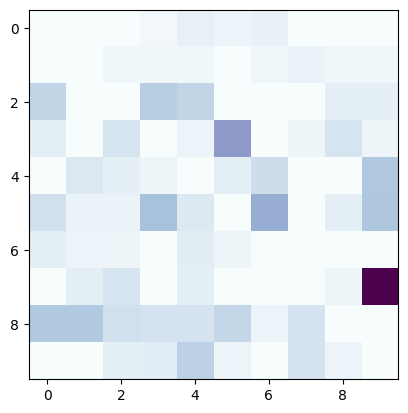

In [19]:
# Answers for q3
# # Compute error rates for each cell
confusion_error_rates = np.zeros((10, 10))
confusion_error_std_devs = np.zeros((10, 10))

# for each run -> compute confusion error rate matrix
# return average and sd across all runs

confusion_error_rate_each_run = np.zeros((20, 10, 10))
for run_idx in range(10): # runs
    for i in range(10):  # true class
        if digit_counts[run_idx,i] > 0:  # To avoid division by zero
            confusion_error_rate_each_run[run_idx, i, :] = confusion_matrices_all[run_idx, i,:] / digit_counts[run_idx,i]
        else:
            confusion_error_rate_each_run[run_idx, i, :] = np.nan

# print(confusion_error_rate_each_run[0])
# plt.imshow(confusion_error_rate_each_run[0])

confusion_error_rate_mean = np.mean(confusion_error_rate_each_run[:3],axis=0)
confusion_error_rate_std = np.std(confusion_error_rate_each_run[:3],axis=0)

print(confusion_error_rate_mean)
plt.imshow(confusion_error_rate_mean,cmap="BuPu")

for i in range(confusion_error_rate_mean.shape[0]):
    for j in range(confusion_error_rate_mean.shape[1]):
        print(f'{confusion_error_rate_mean[i, j]*100:.4f}% +- {confusion_error_rate_std[i, j]*100:.4f}%', end=' ')
    print()  # Newline at the end of each row


### Most misclassified digits

In [20]:
# Answer for q4

# non_zero_indices = misclassified_indices_alldata.nonzero()[0]
# print(non_zero_indices)
# print(misclassified_indices_alldata[non_zero_indices])
sorted_indices = np.argsort(-misclassified_indices_alldata)
# print(sorted_indices)

selected_indices = sorted_indices[:10]
for index in selected_indices:
    print(index,misclassified_indices_alldata[index])


5296 20
8261 15
2340 9
2621 7
5848 7
3227 7
8722 7
8920 7
8284 7
396 6


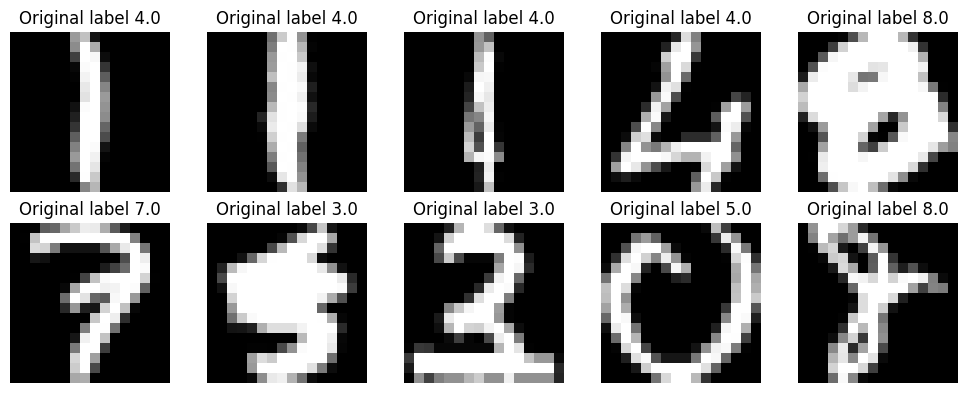

In [21]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
digits_X = all_dataX[selected_indices]
digits_Y = all_dataY[selected_indices]
for i, ax in enumerate(axes.flatten()):
    images = digits_X[i].reshape(16, 16)
    ax.imshow(images, cmap='gray')
    ax.set_title(f'Original label {digits_Y[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# One of the image was predicted wrong in every run-  it looks like it has wrong class labels assigned to it since it looks like the number 1 but has label 4.
# Of the ten images printed, two of them look like 1 but they have label 4 - could be mislabelled. Another image is ambiguous it looks like a 4 and a 1
# Another image with label 5 looks like 0 
# The images are blurry and distorted, and hence, difficult even for humans to identify
# The crossbar in image labelled 7 can make it look like 2 - these could be outliers of the dataset.
# SInce the images are pixellated, it makes sense that the model is limited in its capacity of distinguisshing the images.

### Q5 Gaussian Kernel

In [6]:
# K_train = compute_kernel_matrix(trainX[:20], trainX[:20], 128).shape
train_data,test_data = get_train_test(dataset_alldigits,split_proportion=0.4)
trainX, trainY = train_data[:, 1:], train_data[:, 0]

# K_train = compute_gaussian_kernel(trainX[:20], trainX[:20], 1/(2**14)*2) #.shape
K_train = compute_gaussian_kernel(trainX[:5000], trainX[:5000], (10)**-10).shape

# compute_gaussian_kernel(trainX, trainX, 1)
# K_train

In [7]:
def test_c_values(c_values):
    nsamples_train = int(len(dataset_alldigits)*0.5)
    train_data = dataset_alldigits.iloc[:nsamples_train].to_numpy()
    trainX, trainY = train_data[:, 1:], train_data[:, 0]

    c_all_params = {}
    n_epochs=20
    debug=1

    for c in c_values:
        print(c)
        K_train = compute_gaussian_kernel(trainX, trainX, c)
        if debug:
            print('kernel computed')
        model = kPerceptron(kclasses=10, debug=False)
        train_errors, val_errors = model.fit_online(trainX, trainY, K_train, n_epochs, method='gaussian',gauss_c= c, validation=True)
        plot_learning_curves(train_errors, val_errors,c)

        c_all_params[c] = {'min_error_value': np.min(val_errors), 'epoch_number': np.argmin(val_errors)+1,
                        'avg_val_error':np.mean(val_errors)}
    print(c_all_params)
    return c_all_params

1e-05
kernel computed
---> Test_error: 0.8580645161290322 
---->Epoch 1, train_error: 0.6924 
---> Test_error: 0.832258064516129 
---->Epoch 2, train_error: 0.6494 
---> Test_error: 0.821505376344086 
---->Epoch 3, train_error: 0.5894 
---> Test_error: 0.7870967741935484 
---->Epoch 4, train_error: 0.5752 
---> Test_error: 0.7193548387096774 
---->Epoch 5, train_error: 0.5259 
---> Test_error: 0.6634408602150538 
---->Epoch 6, train_error: 0.477 
---> Test_error: 0.6301075268817204 
---->Epoch 7, train_error: 0.4361 
---> Test_error: 0.6903225806451613 
---->Epoch 8, train_error: 0.3966 
---> Test_error: 0.6827956989247311 
---->Epoch 9, train_error: 0.3665 
---> Test_error: 0.667741935483871 
---->Epoch 10, train_error: 0.345 
---> Test_error: 0.6537634408602151 
---->Epoch 11, train_error: 0.3278 
---> Test_error: 0.6365591397849463 
---->Epoch 12, train_error: 0.3116 
---> Test_error: 0.621505376344086 
---->Epoch 13, train_error: 0.2977 
---> Test_error: 0.5989247311827957 
---->Ep

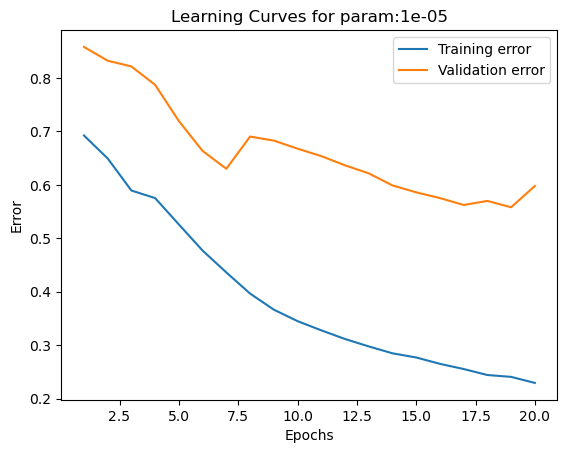

0.0001
kernel computed
---> Test_error: 0.5182795698924731 
---->Epoch 1, train_error: 0.5017 
---> Test_error: 0.5634408602150538 
---->Epoch 2, train_error: 0.2665 
---> Test_error: 0.489247311827957 
---->Epoch 3, train_error: 0.1874 
---> Test_error: 0.4967741935483871 
---->Epoch 4, train_error: 0.1624 
---> Test_error: 0.4935483870967742 
---->Epoch 5, train_error: 0.1468 
---> Test_error: 0.4752688172043011 
---->Epoch 6, train_error: 0.1479 
---> Test_error: 0.44623655913978494 
---->Epoch 7, train_error: 0.1455 
---> Test_error: 0.1935483870967742 
---->Epoch 8, train_error: 0.146 
---> Test_error: 0.17526881720430107 
---->Epoch 9, train_error: 0.1328 
---> Test_error: 0.17311827956989248 
---->Epoch 10, train_error: 0.1218 
---> Test_error: 0.16666666666666666 
---->Epoch 11, train_error: 0.1124 
---> Test_error: 0.16344086021505377 
---->Epoch 12, train_error: 0.1027 
---> Test_error: 0.15376344086021507 
---->Epoch 13, train_error: 0.099 
---> Test_error: 0.221505376344086

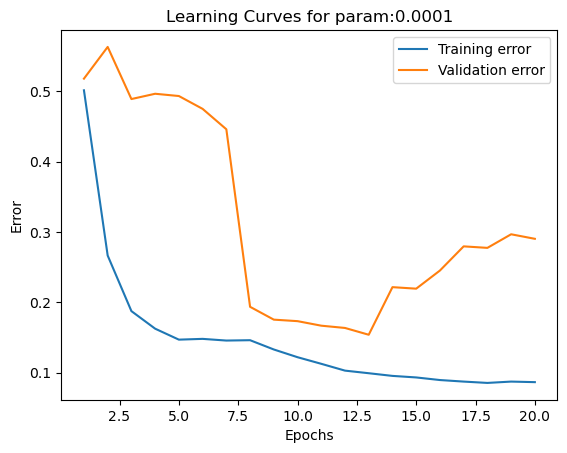

0.001
kernel computed
---> Test_error: 0.24731182795698925 
---->Epoch 1, train_error: 0.1944 
---> Test_error: 0.2010752688172043 
---->Epoch 2, train_error: 0.0928 
---> Test_error: 0.23978494623655913 
---->Epoch 3, train_error: 0.0831 
---> Test_error: 0.13118279569892474 
---->Epoch 4, train_error: 0.0632 
---> Test_error: 0.12258064516129032 
---->Epoch 5, train_error: 0.0524 
---> Test_error: 0.16451612903225807 
---->Epoch 6, train_error: 0.0514 
---> Test_error: 0.12903225806451613 
---->Epoch 7, train_error: 0.05 
---> Test_error: 0.07741935483870968 
---->Epoch 8, train_error: 0.0473 
---> Test_error: 0.07096774193548387 
---->Epoch 9, train_error: 0.0403 
---> Test_error: 0.06666666666666667 
---->Epoch 10, train_error: 0.0385 
---> Test_error: 0.05591397849462366 
---->Epoch 11, train_error: 0.0347 
---> Test_error: 0.07204301075268817 
---->Epoch 12, train_error: 0.0347 
---> Test_error: 0.05268817204301075 
---->Epoch 13, train_error: 0.0293 
---> Test_error: 0.089247311

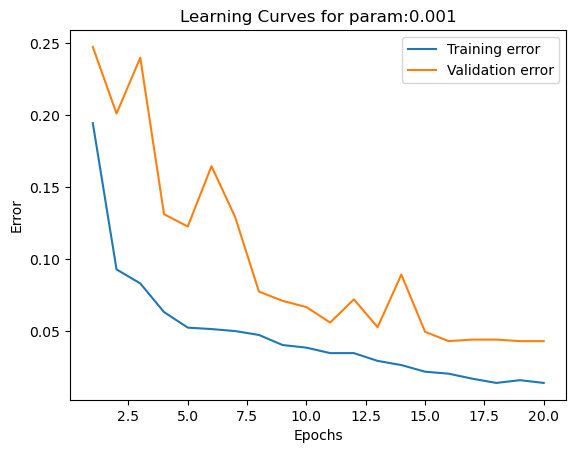

0.01
kernel computed
---> Test_error: 0.06344086021505377 
---->Epoch 1, train_error: 0.0874 
---> Test_error: 0.047311827956989246 
---->Epoch 2, train_error: 0.0086 
---> Test_error: 0.04086021505376344 
---->Epoch 3, train_error: 0.004 
---> Test_error: 0.034408602150537634 
---->Epoch 4, train_error: 0.0008 
---> Test_error: 0.03655913978494624 
---->Epoch 5, train_error: 0.0005 
---> Test_error: 0.03118279569892473 
---->Epoch 6, train_error: 0.0003 
---> Test_error: 0.023655913978494623 
---->Epoch 7, train_error: 0.0003 
---> Test_error: 0.02795698924731183 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.026881720430107527 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---

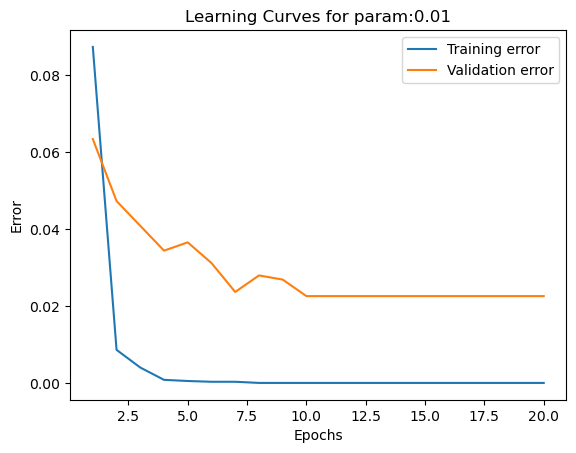

0.1
kernel computed
---> Test_error: 0.0967741935483871 
---->Epoch 1, train_error: 0.1121 
---> Test_error: 0.07634408602150537 
---->Epoch 2, train_error: 0.021 
---> Test_error: 0.07419354838709677 
---->Epoch 3, train_error: 0.0019 
---> Test_error: 0.07419354838709677 
---->Epoch 4, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 14, train_

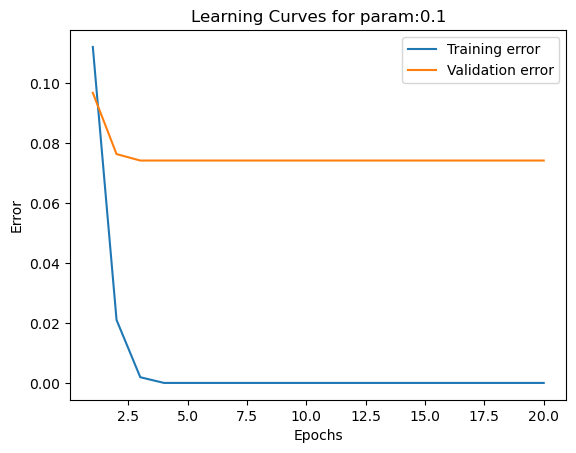

1.0
kernel computed
---> Test_error: 0.12258064516129032 
---->Epoch 1, train_error: 0.1275 
---> Test_error: 0.10215053763440861 
---->Epoch 2, train_error: 0.0328 
---> Test_error: 0.1 
---->Epoch 3, train_error: 0.0027 
---> Test_error: 0.1 
---->Epoch 4, train_error: 0.0003 
---> Test_error: 0.1 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.1 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 14, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 15, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 16, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 17, train_error: 0.0 
---> Te

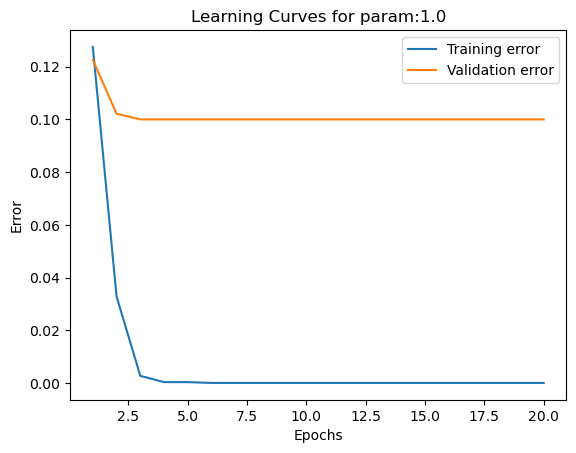

10.0
kernel computed
---> Test_error: 0.34623655913978496 
---->Epoch 1, train_error: 0.3748 
---> Test_error: 0.21397849462365592 
---->Epoch 2, train_error: 0.2525 
---> Test_error: 0.26021505376344084 
---->Epoch 3, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->Epoch 4, train_error: 0.1603 
---> Test_error: 0.26021505376344084 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->Epoch 6, train_error: 0.1603 
---> Test_error: 0.26021505376344084 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->Epoch 8, train_error: 0.1603 
---> Test_error: 0.26021505376344084 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->Epoch 10, train_error: 0.1603 
---> Test_error: 0.26021505376344084 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->Epoch 12, train_error: 0.1603 
---> Test_error: 0.26021505376344084 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.21397849462365592 
---->E

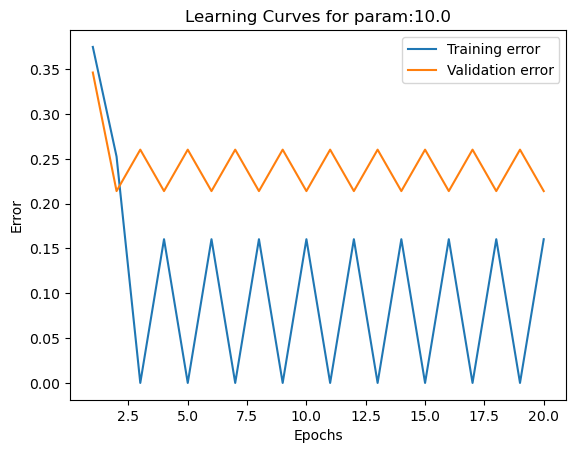

100.0
kernel computed
---> Test_error: 0.7634408602150538 
---->Epoch 1, train_error: 0.7373 
---> Test_error: 0.7548387096774194 
---->Epoch 2, train_error: 0.7163 
---> Test_error: 0.7591397849462366 
---->Epoch 3, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 4, train_error: 0.7005 
---> Test_error: 0.7591397849462366 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 6, train_error: 0.7005 
---> Test_error: 0.7591397849462366 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 8, train_error: 0.7005 
---> Test_error: 0.7591397849462366 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 10, train_error: 0.7005 
---> Test_error: 0.7591397849462366 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 12, train_error: 0.7005 
---> Test_error: 0.7591397849462366 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.7548387096774194 
---->Epoch 14, trai

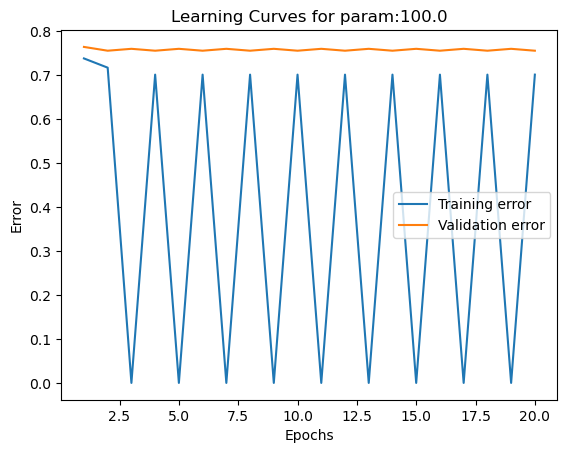

1000.0
kernel computed
---> Test_error: 0.8408602150537634 
---->Epoch 1, train_error: 0.8293 
---> Test_error: 0.8397849462365592 
---->Epoch 2, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 3, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 4, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 6, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 8, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 10, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 12, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.8397849462365592 
---->Epoch 14, tra

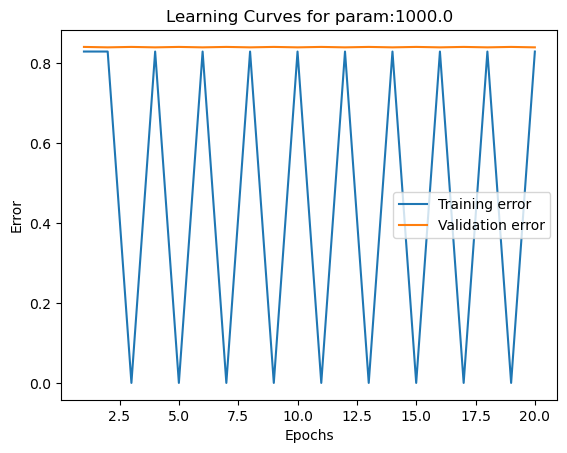

10000.0
kernel computed
---> Test_error: 0.8408602150537634 
---->Epoch 1, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 2, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 3, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 4, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 6, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 8, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 10, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 12, train_error: 0.8293 
---> Test_error: 0.8408602150537634 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.8408602150537634 
---->Epoch 14, tr

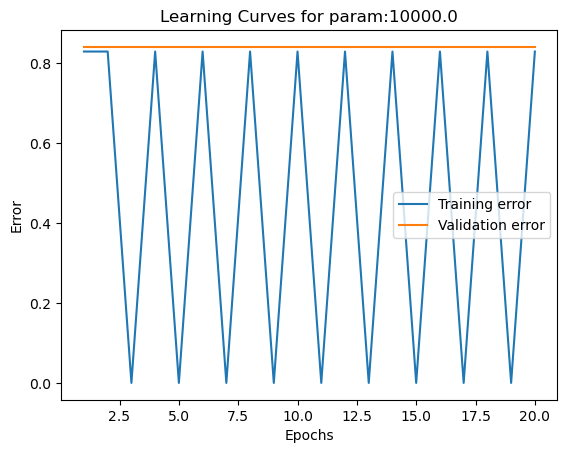

{1e-05: {'min_error_value': 0.5580645161290323, 'epoch_number': 19, 'avg_val_error': 0.6656451612903227}, 0.0001: {'min_error_value': 0.15376344086021507, 'epoch_number': 13, 'avg_val_error': 0.3169354838709677}, 0.001: {'min_error_value': 0.043010752688172046, 'epoch_number': 16, 'avg_val_error': 0.09935483870967743}, 0.01: {'min_error_value': 0.02258064516129032, 'epoch_number': 10, 'avg_val_error': 0.029032258064516127}, 0.1: {'min_error_value': 0.07419354838709677, 'epoch_number': 3, 'avg_val_error': 0.07543010752688172}, 1.0: {'min_error_value': 0.1, 'epoch_number': 3, 'avg_val_error': 0.10123655913978495}, 10.0: {'min_error_value': 0.21397849462365592, 'epoch_number': 2, 'avg_val_error': 0.24139784946236556}, 100.0: {'min_error_value': 0.7548387096774194, 'epoch_number': 2, 'avg_val_error': 0.757204301075269}, 1000.0: {'min_error_value': 0.8397849462365592, 'epoch_number': 2, 'avg_val_error': 0.8403225806451612}, 10000.0: {'min_error_value': 0.8408602150537634, 'epoch_number': 1,

In [8]:
# Initial experiments to determine range of c_values and range of epochs

c_values = [10.0**val for val in np.arange(-5, 5)] # logarithmic scale #TODO
c_all_params = test_c_values(c_values)


In [9]:
for c, metrics in c_all_params.items():
    print(f"gaussian_c: {c},  Epoch Number: {metrics['epoch_number']}, min_error_value: {metrics['min_error_value']}, avg_val_error: {metrics['avg_val_error']} ")

gaussian_c: 1e-05,  Epoch Number: 19, min_error_value: 0.5580645161290323, avg_val_error: 0.6656451612903227 
gaussian_c: 0.0001,  Epoch Number: 13, min_error_value: 0.15376344086021507, avg_val_error: 0.3169354838709677 
gaussian_c: 0.001,  Epoch Number: 16, min_error_value: 0.043010752688172046, avg_val_error: 0.09935483870967743 
gaussian_c: 0.01,  Epoch Number: 10, min_error_value: 0.02258064516129032, avg_val_error: 0.029032258064516127 
gaussian_c: 0.1,  Epoch Number: 3, min_error_value: 0.07419354838709677, avg_val_error: 0.07543010752688172 
gaussian_c: 1.0,  Epoch Number: 3, min_error_value: 0.1, avg_val_error: 0.10123655913978495 
gaussian_c: 10.0,  Epoch Number: 2, min_error_value: 0.21397849462365592, avg_val_error: 0.24139784946236556 
gaussian_c: 100.0,  Epoch Number: 2, min_error_value: 0.7548387096774194, avg_val_error: 0.757204301075269 
gaussian_c: 1000.0,  Epoch Number: 2, min_error_value: 0.8397849462365592, avg_val_error: 0.8403225806451612 
gaussian_c: 10000.0,  E

0.001
kernel computed
---> Test_error: 0.24731182795698925 
---->Epoch 1, train_error: 0.1944 
---> Test_error: 0.2010752688172043 
---->Epoch 2, train_error: 0.0928 
---> Test_error: 0.23978494623655913 
---->Epoch 3, train_error: 0.0831 
---> Test_error: 0.13118279569892474 
---->Epoch 4, train_error: 0.0632 
---> Test_error: 0.12258064516129032 
---->Epoch 5, train_error: 0.0524 
---> Test_error: 0.16451612903225807 
---->Epoch 6, train_error: 0.0514 
---> Test_error: 0.12903225806451613 
---->Epoch 7, train_error: 0.05 
---> Test_error: 0.07741935483870968 
---->Epoch 8, train_error: 0.0473 
---> Test_error: 0.07096774193548387 
---->Epoch 9, train_error: 0.0403 
---> Test_error: 0.06666666666666667 
---->Epoch 10, train_error: 0.0385 
---> Test_error: 0.05591397849462366 
---->Epoch 11, train_error: 0.0347 
---> Test_error: 0.07204301075268817 
---->Epoch 12, train_error: 0.0347 
---> Test_error: 0.05268817204301075 
---->Epoch 13, train_error: 0.0293 
---> Test_error: 0.089247311

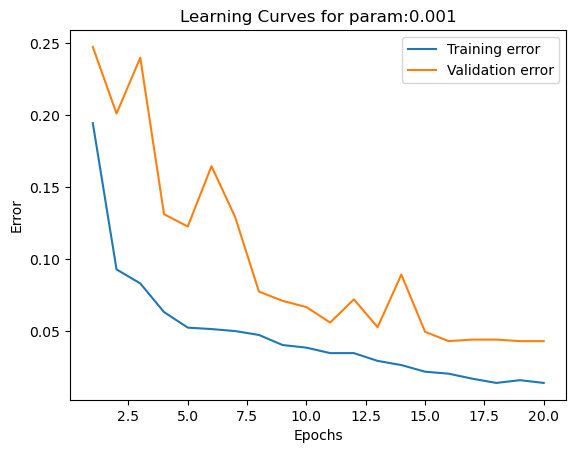

0.0021544346900318843
kernel computed
---> Test_error: 0.2161290322580645 
---->Epoch 1, train_error: 0.1465 
---> Test_error: 0.08602150537634409 
---->Epoch 2, train_error: 0.068 
---> Test_error: 0.06451612903225806 
---->Epoch 3, train_error: 0.0409 
---> Test_error: 0.1 
---->Epoch 4, train_error: 0.0331 
---> Test_error: 0.04408602150537634 
---->Epoch 5, train_error: 0.0258 
---> Test_error: 0.043010752688172046 
---->Epoch 6, train_error: 0.022 
---> Test_error: 0.03978494623655914 
---->Epoch 7, train_error: 0.0126 
---> Test_error: 0.03870967741935484 
---->Epoch 8, train_error: 0.0089 
---> Test_error: 0.03655913978494624 
---->Epoch 9, train_error: 0.0059 
---> Test_error: 0.03655913978494624 
---->Epoch 10, train_error: 0.0089 
---> Test_error: 0.03763440860215054 
---->Epoch 11, train_error: 0.0073 
---> Test_error: 0.04086021505376344 
---->Epoch 12, train_error: 0.0051 
---> Test_error: 0.054838709677419356 
---->Epoch 13, train_error: 0.0024 
---> Test_error: 0.0473118

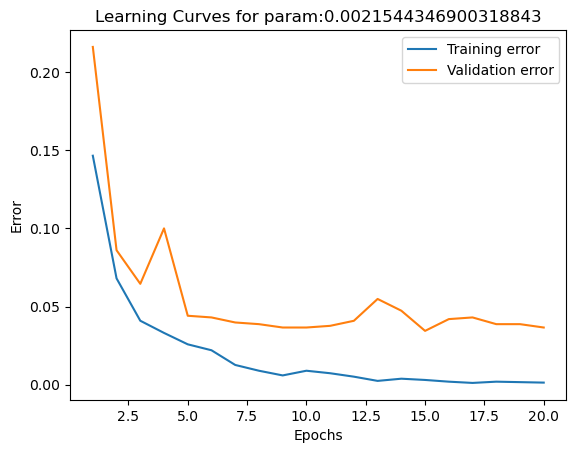

0.004641588833612777
kernel computed
---> Test_error: 0.0913978494623656 
---->Epoch 1, train_error: 0.1057 
---> Test_error: 0.08064516129032258 
---->Epoch 2, train_error: 0.0307 
---> Test_error: 0.05913978494623656 
---->Epoch 3, train_error: 0.0134 
---> Test_error: 0.047311827956989246 
---->Epoch 4, train_error: 0.0078 
---> Test_error: 0.046236559139784944 
---->Epoch 5, train_error: 0.0051 
---> Test_error: 0.03978494623655914 
---->Epoch 6, train_error: 0.0054 
---> Test_error: 0.04946236559139785 
---->Epoch 7, train_error: 0.0022 
---> Test_error: 0.03655913978494624 
---->Epoch 8, train_error: 0.0016 
---> Test_error: 0.035483870967741936 
---->Epoch 9, train_error: 0.0016 
---> Test_error: 0.041935483870967745 
---->Epoch 10, train_error: 0.0003 
---> Test_error: 0.035483870967741936 
---->Epoch 11, train_error: 0.0011 
---> Test_error: 0.03333333333333333 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.03225806451612903 
---->Epoch 13, train_error: 0.0 
---> Test_er

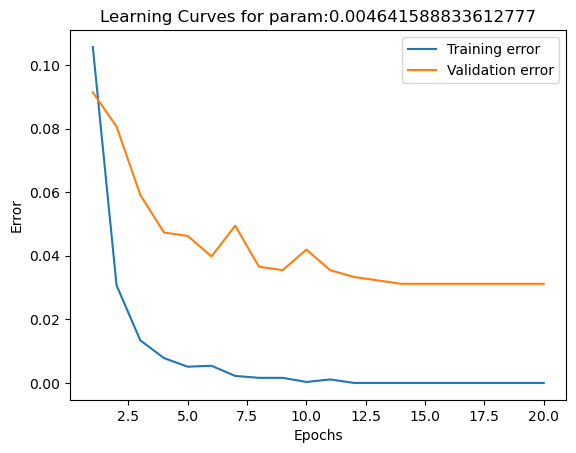

0.01
kernel computed
---> Test_error: 0.06344086021505377 
---->Epoch 1, train_error: 0.0874 
---> Test_error: 0.047311827956989246 
---->Epoch 2, train_error: 0.0086 
---> Test_error: 0.04086021505376344 
---->Epoch 3, train_error: 0.004 
---> Test_error: 0.034408602150537634 
---->Epoch 4, train_error: 0.0008 
---> Test_error: 0.03655913978494624 
---->Epoch 5, train_error: 0.0005 
---> Test_error: 0.03118279569892473 
---->Epoch 6, train_error: 0.0003 
---> Test_error: 0.023655913978494623 
---->Epoch 7, train_error: 0.0003 
---> Test_error: 0.02795698924731183 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.026881720430107527 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.02258064516129032 
---

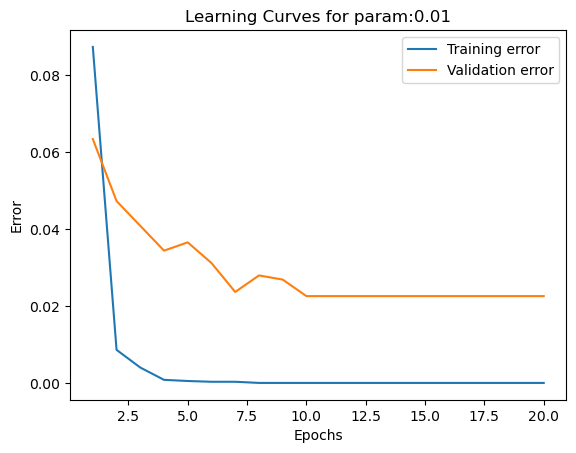

0.021544346900318832
kernel computed
---> Test_error: 0.06881720430107527 
---->Epoch 1, train_error: 0.0715 
---> Test_error: 0.03763440860215054 
---->Epoch 2, train_error: 0.0073 
---> Test_error: 0.03763440860215054 
---->Epoch 3, train_error: 0.0005 
---> Test_error: 0.034408602150537634 
---->Epoch 4, train_error: 0.0003 
---> Test_error: 0.034408602150537634 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.034408602150537634 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.034408602150537634 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.03440

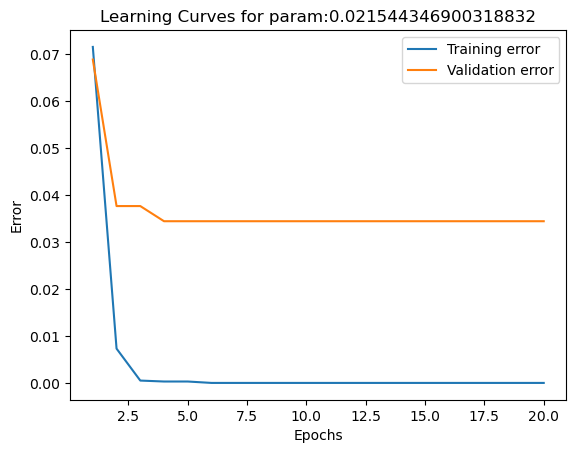

0.046415888336127774
kernel computed
---> Test_error: 0.06666666666666667 
---->Epoch 1, train_error: 0.0917 
---> Test_error: 0.05161290322580645 
---->Epoch 2, train_error: 0.0118 
---> Test_error: 0.05268817204301075 
---->Epoch 3, train_error: 0.0022 
---> Test_error: 0.05268817204301075 
---->Epoch 4, train_error: 0.0003 
---> Test_error: 0.05268817204301075 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.05268817204301075 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.05268817204301075 

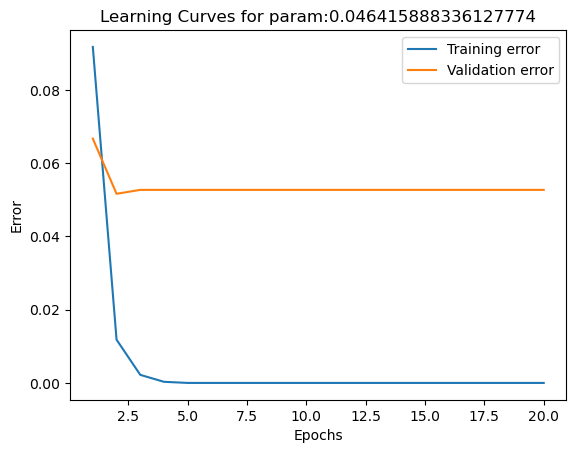

0.1
kernel computed
---> Test_error: 0.0967741935483871 
---->Epoch 1, train_error: 0.1121 
---> Test_error: 0.07634408602150537 
---->Epoch 2, train_error: 0.021 
---> Test_error: 0.07419354838709677 
---->Epoch 3, train_error: 0.0019 
---> Test_error: 0.07419354838709677 
---->Epoch 4, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.07419354838709677 
---->Epoch 14, train_

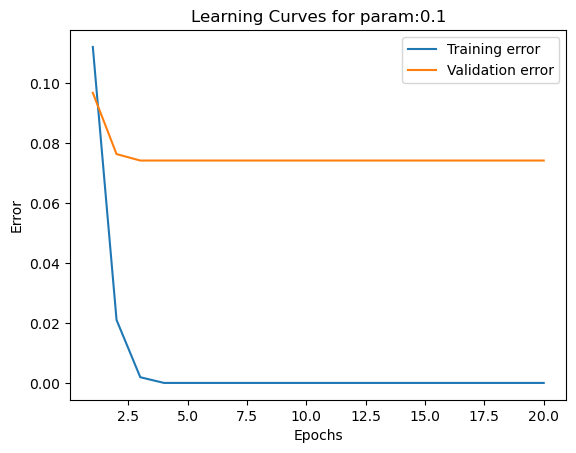

0.21544346900318823
kernel computed
---> Test_error: 0.11612903225806452 
---->Epoch 1, train_error: 0.1248 
---> Test_error: 0.0989247311827957 
---->Epoch 2, train_error: 0.028 
---> Test_error: 0.0935483870967742 
---->Epoch 3, train_error: 0.0038 
---> Test_error: 0.0935483870967742 
---->Epoch 4, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 5, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.0935483870967742 
---->Epoch 14, tr

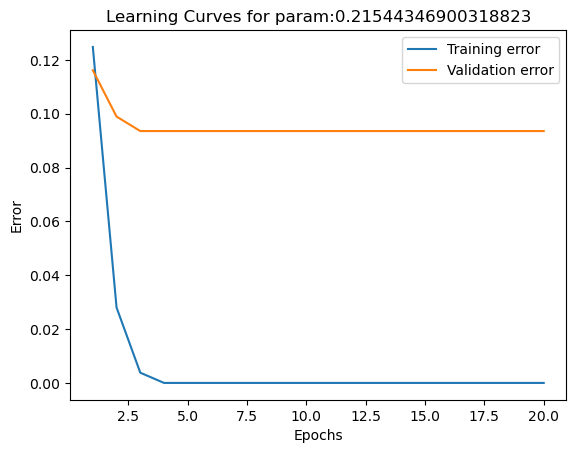

0.46415888336127775
kernel computed
---> Test_error: 0.11827956989247312 
---->Epoch 1, train_error: 0.1261 
---> Test_error: 0.1 
---->Epoch 2, train_error: 0.0296 
---> Test_error: 0.0956989247311828 
---->Epoch 3, train_error: 0.0027 
---> Test_error: 0.0956989247311828 
---->Epoch 4, train_error: 0.0003 
---> Test_error: 0.0956989247311828 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.0956989247311828 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.0956989247311828 
---->Epoch 14, train_erro

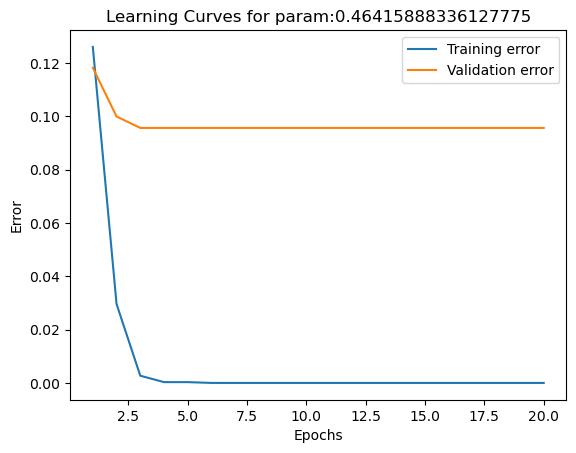

1.0
kernel computed
---> Test_error: 0.12258064516129032 
---->Epoch 1, train_error: 0.1275 
---> Test_error: 0.10215053763440861 
---->Epoch 2, train_error: 0.0328 
---> Test_error: 0.1 
---->Epoch 3, train_error: 0.0027 
---> Test_error: 0.1 
---->Epoch 4, train_error: 0.0003 
---> Test_error: 0.1 
---->Epoch 5, train_error: 0.0003 
---> Test_error: 0.1 
---->Epoch 6, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 7, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 8, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 9, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 10, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 11, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 12, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 13, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 14, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 15, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 16, train_error: 0.0 
---> Test_error: 0.1 
---->Epoch 17, train_error: 0.0 
---> Te

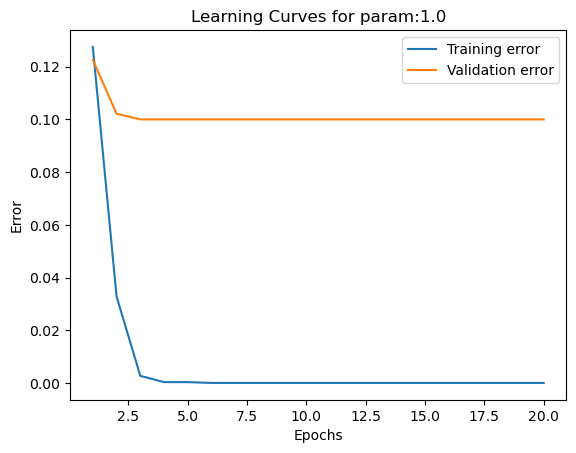

{0.001: {'min_error_value': 0.043010752688172046, 'epoch_number': 16, 'avg_val_error': 0.09935483870967743}, 0.0021544346900318843: {'min_error_value': 0.034408602150537634, 'epoch_number': 15, 'avg_val_error': 0.055967741935483886}, 0.004641588833612777: {'min_error_value': 0.03118279569892473, 'epoch_number': 14, 'avg_val_error': 0.042365591397849456}, 0.01: {'min_error_value': 0.02258064516129032, 'epoch_number': 10, 'avg_val_error': 0.029032258064516127}, 0.021544346900318832: {'min_error_value': 0.034408602150537634, 'epoch_number': 4, 'avg_val_error': 0.03645161290322581}, 0.046415888336127774: {'min_error_value': 0.05161290322580645, 'epoch_number': 2, 'avg_val_error': 0.053333333333333344}, 0.1: {'min_error_value': 0.07419354838709677, 'epoch_number': 3, 'avg_val_error': 0.07543010752688172}, 0.21544346900318823: {'min_error_value': 0.0935483870967742, 'epoch_number': 3, 'avg_val_error': 0.09494623655913978}, 0.46415888336127775: {'min_error_value': 0.0956989247311828, 'epoch_n

In [12]:
c_values = np.logspace(-3, 0, 10)
c_all_params = test_c_values(c_values)


In [13]:
for c, metrics in c_all_params.items():
    print(f"gaussian_c: {c},  Epoch Number: {metrics['epoch_number']}, min_error_value: {metrics['min_error_value']}, avg_val_error: {metrics['avg_val_error']} ")

gaussian_c: 0.001,  Epoch Number: 16, min_error_value: 0.043010752688172046, avg_val_error: 0.09935483870967743 
gaussian_c: 0.0021544346900318843,  Epoch Number: 15, min_error_value: 0.034408602150537634, avg_val_error: 0.055967741935483886 
gaussian_c: 0.004641588833612777,  Epoch Number: 14, min_error_value: 0.03118279569892473, avg_val_error: 0.042365591397849456 
gaussian_c: 0.01,  Epoch Number: 10, min_error_value: 0.02258064516129032, avg_val_error: 0.029032258064516127 
gaussian_c: 0.021544346900318832,  Epoch Number: 4, min_error_value: 0.034408602150537634, avg_val_error: 0.03645161290322581 
gaussian_c: 0.046415888336127774,  Epoch Number: 2, min_error_value: 0.05161290322580645, avg_val_error: 0.053333333333333344 
gaussian_c: 0.1,  Epoch Number: 3, min_error_value: 0.07419354838709677, avg_val_error: 0.07543010752688172 
gaussian_c: 0.21544346900318823,  Epoch Number: 3, min_error_value: 0.0935483870967742, avg_val_error: 0.09494623655913978 
gaussian_c: 0.4641588833612777

In [16]:
# Code for Q5 - repetition of Q1 with gaussian kernel

# c_values = [0.0001, 0.005, 0.001,0.05,0.01,0.5]
c_values = np.logspace(-3, -1, 10)

train_error_c = {}
test_error_c = {}
for idx in c_values:
    train_error_c[idx] = []
    test_error_c[idx] = []

start_time = time.time()
n_epochs = 15
for repeat in range(20): #TODO: 20

    print(f'Run {repeat+1}/20: ')
    # Split data into train and test
    train_data, test_data = get_train_test(dataset_alldigits,split_proportion=0.8)
    trainX, trainY = train_data[:, 1:], train_data[:, 0]
    testX, testY = test_data[:, 1:], test_data[:, 0]
    # print(len(test_data), len(test_data), trainY[0], testY[0] )

    for iter_c in c_values:
        print(f'c: {iter_c}')
        K_train = compute_gaussian_kernel(trainX, trainX, iter_c)

        model = kPerceptron(kclasses=10, debug=False)
        train_error = model.fit_online(trainX= trainX, trainY = trainY, kernel_matrix_train = K_train, n_epochs=n_epochs, method='gaussian',gauss_c= iter_c)
        _,test_error = model.test(testX, testY)

        train_error_c[iter_c].append(train_error)
        test_error_c[iter_c].append(test_error)

testing_time = time.time() - start_time
print(f"Algorithm took {testing_time:.2f} seconds")

Run 1/20: 
c: 0.001
---->Epoch 1, train_error: 0.1734 
---->Epoch 2, train_error: 0.0965 
---->Epoch 3, train_error: 0.0799 
---->Epoch 4, train_error: 0.0694 
---->Epoch 5, train_error: 0.0621 
---->Epoch 6, train_error: 0.0538 
---->Epoch 7, train_error: 0.0484 
---->Epoch 8, train_error: 0.0475 
---->Epoch 9, train_error: 0.0411 
---->Epoch 10, train_error: 0.0403 
---->Epoch 11, train_error: 0.0372 
---->Epoch 12, train_error: 0.0354 
---->Epoch 13, train_error: 0.0304 
---->Epoch 14, train_error: 0.0301 
---->Epoch 15, train_error: 0.029 
---> Test_error: 0.1053763440860215 
c: 0.0016681005372000592
---->Epoch 1, train_error: 0.1422 
---->Epoch 2, train_error: 0.0721 
---->Epoch 3, train_error: 0.0561 
---->Epoch 4, train_error: 0.0442 
---->Epoch 5, train_error: 0.0354 
---->Epoch 6, train_error: 0.03 
---->Epoch 7, train_error: 0.0277 
---->Epoch 8, train_error: 0.025 
---->Epoch 9, train_error: 0.023 
---->Epoch 10, train_error: 0.018 
---->Epoch 11, train_error: 0.0176 
---->E

In [17]:
# 5 - 1. Answers
mean_train_error, mean_test_error, sd_train_error, sd_test_error = {}, {}, {}, {}

for key, values in train_error_c.items():
    mean_train_error[key] = np.mean(values)
    sd_train_error[key] = np.std(values)
for key, values in test_error_c.items():
    mean_test_error[key] = np.mean(values)
    sd_test_error[key] = np.std(values)

print('Mean of Train errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in mean_train_error.items()))
print('SD of Train errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in sd_train_error.items()))
print('Mean of Test errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in mean_test_error.items()))
print('SD of Test errors for each d \n ',', '.join(f'{key}: {value:.6f}' for key, value in sd_test_error.items()))

Mean of Train errors for each d 
  0.001: 0.028805, 0.0016681005372000592: 0.010825, 0.0027825594022071257: 0.002235, 0.004641588833612777: 0.000505, 0.007742636826811269: 0.000200, 0.01291549665014884: 0.000190, 0.021544346900318832: 0.000160, 0.03593813663804626: 0.000130, 0.05994842503189409: 0.000020, 0.1: 0.000000
SD of Train errors for each d 
  0.001: 0.001664, 0.0016681005372000592: 0.001381, 0.0027825594022071257: 0.000825, 0.004641588833612777: 0.000322, 0.007742636826811269: 0.000148, 0.01291549665014884: 0.000148, 0.021544346900318832: 0.000143, 0.03593813663804626: 0.000119, 0.05994842503189409: 0.000068, 0.1: 0.000000
Mean of Test errors for each d 
  0.001: 0.060108, 0.0016681005372000592: 0.046882, 0.0027825594022071257: 0.034731, 0.004641588833612777: 0.030403, 0.007742636826811269: 0.027258, 0.01291549665014884: 0.026505, 0.021544346900318832: 0.025780, 0.03593813663804626: 0.032043, 0.05994842503189409: 0.042392, 0.1: 0.052634
SD of Test errors for each d 
  0.001: 0

In [18]:
# 2. Cross-validation: 20 runs : 5-fold cross-validation to select the “best” parameter c
# then retrain on full 80% training set using c and then record the test errors on the remaining 20%.
# Your final result will consist of a mean test error±std and a mean c with std

c_values = np.logspace(-3, -1, 10)

best_20_c = [] # best 20 of poly_dim in crossvalidation
test_errors_chosen_params = []

start_time = time.time()
n_epochs = 15

for repeat in range(20): #TODO:20
    print(f'Run {repeat+1}/20: ')
    # Split data into train and test
    big_train_data, final_test_data = get_train_test(dataset_alldigits, split_proportion=0.8)

    big_train_dataX, big_train_dataY = big_train_data[:, 1:], big_train_data[:, 0]
    final_test_dataX, final_test_dataY = final_test_data[:, 1:], final_test_data[:, 0]


    # Create folds for cross validation
    n_folds = 5
    fold_size = int(len(big_train_data)/n_folds)
    fold_indices = []
    indices = np.arange(len(big_train_data))
    for i in range(n_folds):
        start_idx, end_idx = i * fold_size,  (i + 1) * fold_size
        validation_indices = indices[start_idx: end_idx]
        train_indices = np.concatenate([indices[:start_idx], indices[end_idx:]])
        fold_indices.append((train_indices, validation_indices))

    chosen_c = None
    best_score = float('inf')
    cv_errors = np.zeros(len(c_values))

    # 5 folds*7 gammas
    print('--Iterating over c_values')
    for iter_c in c_values:
        print(f'-->c_value: {iter_c}')
        fold_scores = []
        for fold_num, (train_indices, validation_indices) in enumerate(fold_indices):
            print("--->Fold ",fold_num)
            train_foldX, validation_foldX = big_train_dataX[train_indices], big_train_dataX[validation_indices]
            train_foldY, validation_foldY = big_train_dataY[train_indices], big_train_dataY[validation_indices]

            # Train the model on the training data and make predictions on the validation data
            K_trainfold = compute_gaussian_kernel(train_foldX, train_foldX, iter_c)
            train_error = model.fit_online(trainX= train_foldX, trainY = train_foldY, kernel_matrix_train = K_trainfold, n_epochs=n_epochs, method='gaussian',gauss_c= iter_c)
            _,validation_error = model.test(validation_foldX, validation_foldY)
            # print(train_error, validation_error)
            fold_scores.append(validation_error)

        average_score = np.mean(fold_scores)
        if average_score < best_score:
            best_score = average_score
            chosen_c = iter_c
    print('** Best c for the run :',chosen_c, 'with average test error:',best_score)
    best_20_c.append(chosen_c)


    # Retrain the model with best d on the entire training set and get error on test set
    K_big_train_data = compute_gaussian_kernel(big_train_dataX, big_train_dataX, chosen_c)
    model = kPerceptron(kclasses=10, debug=False)
    train_error = model.fit_online(trainX= big_train_dataX, trainY = big_train_dataY, kernel_matrix_train = K_big_train_data, n_epochs=n_epochs, method='gaussian',gauss_c= chosen_c)
    _, test_error = model.test(final_test_dataX, final_test_dataY)

    print('--> Test set error',test_error)
    test_errors_chosen_params.append(test_error)

crossval_time = time.time() - start_time
print(f"Algorithm took {crossval_time:.2f} seconds")

Run 1/20: 
--Iterating over c_values
-->c_value: 0.001
--->Fold  0
---->Epoch 1, train_error: 0.1911 
---->Epoch 2, train_error: 0.1038 
---->Epoch 3, train_error: 0.0823 
---->Epoch 4, train_error: 0.0751 
---->Epoch 5, train_error: 0.0627 
---->Epoch 6, train_error: 0.056 
---->Epoch 7, train_error: 0.0513 
---->Epoch 8, train_error: 0.0479 
---->Epoch 9, train_error: 0.0413 
---->Epoch 10, train_error: 0.0415 
---->Epoch 11, train_error: 0.0397 
---->Epoch 12, train_error: 0.035 
---->Epoch 13, train_error: 0.0292 
---->Epoch 14, train_error: 0.0276 
---->Epoch 15, train_error: 0.0232 
---> Test_error: 0.06321452589105582 
--->Fold  1
---->Epoch 1, train_error: 0.1877 
---->Epoch 2, train_error: 0.1018 
---->Epoch 3, train_error: 0.0881 
---->Epoch 4, train_error: 0.0743 
---->Epoch 5, train_error: 0.0654 
---->Epoch 6, train_error: 0.0593 
---->Epoch 7, train_error: 0.0516 
---->Epoch 8, train_error: 0.0496 
---->Epoch 9, train_error: 0.0472 
---->Epoch 10, train_error: 0.0462 
---

In [19]:
# 5 - 2. Answers
print(best_20_c)
test_errors_chosen_params = np.array(test_errors_chosen_params)
print(test_errors_chosen_params, test_errors_chosen_params.mean(), test_errors_chosen_params.std())

[0.01291549665014884, 0.021544346900318832, 0.01291549665014884, 0.021544346900318832, 0.021544346900318832, 0.021544346900318832, 0.01291549665014884, 0.01291549665014884, 0.007742636826811269, 0.01291549665014884, 0.01291549665014884, 0.021544346900318832, 0.01291549665014884, 0.021544346900318832, 0.021544346900318832, 0.01291549665014884, 0.021544346900318832, 0.01291549665014884, 0.021544346900318832, 0.021544346900318832]
[0.02311828 0.02204301 0.02688172 0.02634409 0.02741935 0.01935484
 0.02419355 0.02096774 0.02365591 0.03064516 0.02258065 0.02956989
 0.02956989 0.0311828  0.02096774 0.02849462 0.03064516 0.02419355
 0.02956989 0.02795699] 0.025967741935483866 0.0036309234419146332


In [5]:
np.mean(best_20_c), np.std(best_20_c)

(0.016971278784066957, 0.004702880345034835)

### Q6

Done in the second notebook
